# P2: Double-Well SDE Simulation

Simulates the nonlinear double-well SDE:

$$dX_t = (\alpha X_t - \beta X_t^3)dt + \sigma dW_t$$

with $\alpha = \beta = 1$, $\sigma = 0.25$, $X_0 \sim N(0,1)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [2]:
# Parameters
alpha = 1.0
beta = 1.0
sigma = 0.25
T = 50.0
dt = 0.01
n_sims = 1000
seed = 42

In [3]:
# Copied from utils.em_simulator.py
def eu_simulator(f_t, g_t, W_t, x0, T, dt):
    """
    Simulate an SDE using the Euler-Maruyama method.
    
    Parameters:
    f_t: function - the drift function f(X_t)
    g_t: function - the diffusion function g(X_t)
    W_t: array-like - the Wiener process increments
    x0: float - initial condition
    T: float - total time to simulate
    dt: float - time step size
    
    Returns:
    X: array - simulated values of X_t at each time step
    """
    N = int(T / dt)  # number of time steps
    X = np.zeros(N + 1)
    X[0] = x0
    
    for i in range(1, N + 1):
        t = i * dt
        dW = W_t[i-1]  # Wiener increment for this time step
        X[i] = X[i-1] + f_t(X[i-1]) * dt + g_t(X[i-1]) * dW
        
    return X

def make_double_well_drift(alpha, beta):
    """Return f_t(x) = alpha * x - beta * x^3 for double-well process."""
    return lambda x: alpha * x - beta * (x**3)

def make_constant_diffusion(sigma):
    """Return g_t(x) = sigma (constant diffusion)."""
    return lambda x: sigma

In [4]:
def generate_double_well_paths(alpha, beta, sigma, T, dt, n_sims, seed=None):
    """
    Generate multiple independent double-well SDE paths.
    X_0 ~ N(0, 1) for each path.
    
    Returns:
        X_panel: array of shape (n_sims, N+1) where N = T/dt
    """
    N = int(T / dt)
    rng = np.random.default_rng(seed)
    X_panel = np.empty((n_sims, N + 1), dtype=np.float64)
    
    f_t = make_double_well_drift(alpha, beta)
    g_t = make_constant_diffusion(sigma)
    
    for i in range(n_sims):
        W = rng.normal(0.0, np.sqrt(dt), size=N)
        x0 = rng.normal(0.0, 1.0)  # X_0 ~ N(0,1)
        X_panel[i] = eu_simulator(f_t, g_t, W, x0, T, dt)
    
    return X_panel

In [5]:
# Generate simulations
print(f"Generating {n_sims} double-well trajectories...")
X_panel = generate_double_well_paths(alpha, beta, sigma, T, dt, n_sims, seed=seed)
print(f"Simulation complete. Shape: {X_panel.shape}")

Generating 1000 double-well trajectories...
Simulation complete. Shape: (1000, 5001)


In [6]:
def compute_moments(X_panel, K=10):
    """
    Compute raw moments up to order K at each time step.
    
    Parameters:
        X_panel: array of shape (n_sims, T_plus) where T_plus = N+1
        K: int - highest moment order (default 10)
    
    Returns:
        moments: array of shape (T_plus, K) with columns [m1, m2, ..., mK]
                 where m_k = E[X^k] (k-th raw moment)
    """
    n_sims, T_plus = X_panel.shape
    moments = np.empty((T_plus, K), dtype=np.float64)
    
    for t in range(T_plus):
        X_t = X_panel[:, t]
        for k in range(1, K + 1):
            moments[t, k - 1] = np.mean(X_t**k)  # k-th raw moment
    
    return moments

In [7]:
def schatten_l2_normalize(moments):
    """
    Apply Schatten-L2 (Frobenius) normalization to moment matrix.
    
    Parameters:
        moments: array of shape (T, K) where K is number of moment types
    
    Returns:
        normalized_moments: array of same shape, with ||M||_F = 1
    """
    frobenius_norm = np.linalg.norm(moments, ord='fro')
    return moments / frobenius_norm

In [8]:
# Compute moments (up to 10th order)
print("Computing moments (up to 10th order) at each time step...")
moments = compute_moments(X_panel, K=10)
print(f"Moments shape: {moments.shape}")
print(f"Each row contains: [m1, m2, m3, ..., m10] where m_k = E[X^k]")

# Apply Schatten-L2 normalization
print("\nApplying Schatten-L2 normalization...")
normalized_moments = schatten_l2_normalize(moments)
print(f"Frobenius norm of normalized moments: {np.linalg.norm(normalized_moments, ord='fro'):.6f}")

Computing moments (up to 10th order) at each time step...
Moments shape: (5001, 10)
Each row contains: [m1, m2, m3, ..., m10] where m_k = E[X^k]

Applying Schatten-L2 normalization...
Frobenius norm of normalized moments: 1.000000


In [9]:
# Save raw simulation data
print("Saving raw simulation data...")
df_sim = pd.DataFrame(X_panel)
df_sim.to_csv('../data/dw_process_simulation.csv', index=False)
print("Saved to data/dw_process_simulation.csv")

Saving raw simulation data...
Saved to data/dw_process_simulation.csv


In [10]:
# Save normalized moments
print("Saving normalized moments...")
df_moments = pd.DataFrame(
    normalized_moments,
    columns=[f'm{k}' for k in range(1, 11)]  # m1, m2, ..., m10
)
df_moments.to_csv('../data/DoubleWell_moments.csv', index=False)
print("Saved to data/DoubleWell_moments.csv")
print(f"Columns: {list(df_moments.columns)}")

Saving normalized moments...
Saved to data/DoubleWell_moments.csv
Columns: ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10']


Creating final histogram...
Saved histogram to outputs/double_well_final_histogram.png


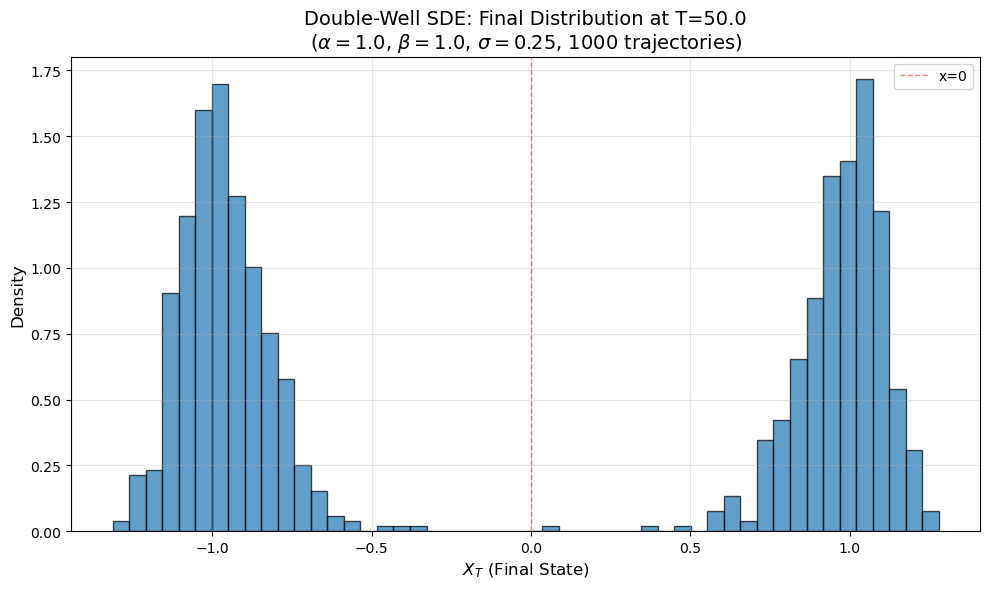


Final state statistics:
  Mean: -0.0361
  Std:  0.9775
  Min:  -1.3133
  Max:  1.2793


In [11]:
# Plot final histogram (should show two wells)
print("Creating final histogram...")
fig, ax = plt.subplots(figsize=(10, 6))

# Get final time step values
X_final = X_panel[:, -1]

ax.hist(X_final, bins=50, density=True, alpha=0.7, edgecolor='black')
ax.set_xlabel('$X_T$ (Final State)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Double-Well SDE: Final Distribution at T={T}\n'
             f'($\\alpha={alpha}$, $\\beta={beta}$, $\\sigma={sigma}$, {n_sims} trajectories)',
             fontsize=14)
ax.grid(True, alpha=0.3)
ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='x=0')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/double_well_final_histogram.png', dpi=150, bbox_inches='tight')
print("Saved histogram to outputs/double_well_final_histogram.png")
plt.show()

print(f"\nFinal state statistics:")
print(f"  Mean: {np.mean(X_final):.4f}")
print(f"  Std:  {np.std(X_final):.4f}")
print(f"  Min:  {np.min(X_final):.4f}")
print(f"  Max:  {np.max(X_final):.4f}")

Saved sample trajectories to outputs/double_well_sample_trajectories.png


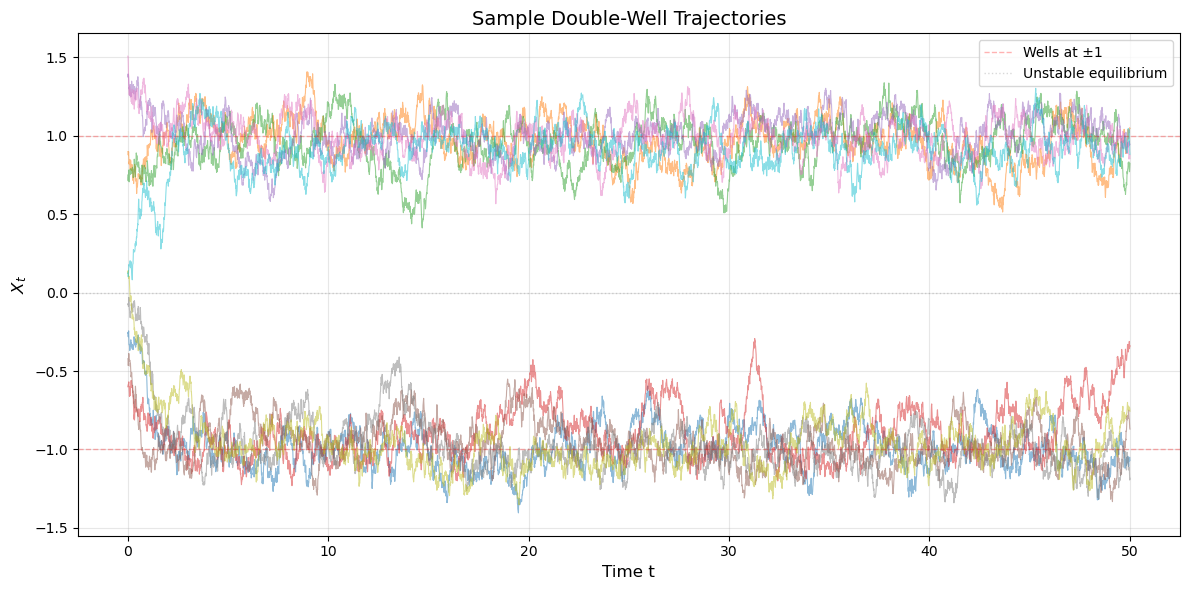

In [12]:
# Optional: Plot a few sample trajectories
fig, ax = plt.subplots(figsize=(12, 6))

times = np.linspace(0, T, X_panel.shape[1])
for i in range(min(10, n_sims)):
    ax.plot(times, X_panel[i], alpha=0.5, linewidth=0.8)

ax.set_xlabel('Time t', fontsize=12)
ax.set_ylabel('$X_t$', fontsize=12)
ax.set_title('Sample Double-Well Trajectories', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Wells at ±1')
ax.axhline(-1, color='red', linestyle='--', linewidth=1, alpha=0.3)
ax.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.3, label='Unstable equilibrium')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/double_well_sample_trajectories.png', dpi=150, bbox_inches='tight')
print("Saved sample trajectories to outputs/double_well_sample_trajectories.png")
plt.show()

In [13]:
# Summary
print("\n" + "="*60)
print("P2 DOUBLE-WELL SDE SIMULATION COMPLETE")
print("="*60)
print(f"Parameters:")
print(f"  α = {alpha}, β = {beta}, σ = {sigma}")
print(f"  T = {T}, dt = {dt}, n_sims = {n_sims}")
print(f"\nOutputs:")
print(f"  ✓ data/dw_process_simulation.csv")
print(f"  ✓ data/DoubleWell_moments.csv")
print(f"  ✓ outputs/double_well_final_histogram.png")
print(f"  ✓ outputs/double_well_sample_trajectories.png")
print("="*60)


P2 DOUBLE-WELL SDE SIMULATION COMPLETE
Parameters:
  α = 1.0, β = 1.0, σ = 0.25
  T = 50.0, dt = 0.01, n_sims = 1000

Outputs:
  ✓ data/dw_process_simulation.csv
  ✓ data/DoubleWell_moments.csv
  ✓ outputs/double_well_final_histogram.png
  ✓ outputs/double_well_sample_trajectories.png
